In [1]:
import pandas as pd
import numpy as np
import seaborn as sbs

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
print("Versions:",
      "pandas", pd.__version__,
      "| numpy", np.__version__)

Versions: pandas 2.3.3 | numpy 2.3.3


In [2]:
df = sbs.load_dataset("titanic")
df.head(5)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
df.info()
df.isna().mean().sort_values(ascending=False).to_frame("missing_rate")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


,missing_rate
deck,0.772166
age,0.198653
embarked,0.002245
embark_town,0.002245
survived,0.000000
pclass,0.000000
sex,0.000000
sibsp,0.000000
parch,0.000000
fare,0.000000


In [4]:
keep = ["survived", "pclass", "sex", "age", "sibsp", "parch", "fare", "embarked", "alone"]
df =df[keep].copy()
df.head(5)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,alone
0,0,3,male,22.0,1,0,7.2500,S,False
1,1,1,female,38.0,1,0,71.2833,C,False
2,1,3,female,26.0,0,0,7.9250,S,True
3,1,1,female,35.0,1,0,53.1000,S,False
4,0,3,male,35.0,0,0,8.0500,S,True


In [5]:
age_medians = df.groupby(["sex", "pclass"])["age"].median()
def impute_age(row):
    if pd.isna(row["age"]):
        return age_medians.loc[(row["sex"], row["pclass"])]
    return row["age"]

df["age"] = df.apply(impute_age, axis=1)

embarked_mode = df["embarked"].mode(dropna=True)[0]
df["embarked"] = df["embarked"].fillna(embarked_mode)

df["fare"] = df["fare"].fillna(df["fare"].median())

df.isna().sum()

survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
alone       0
dtype: int64

In [6]:
df.describe(include="all")
df.dtypes

survived      int64
pclass        int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
embarked     object
alone          bool
dtype: object

In [7]:
from pathlib import Path
Path("data").mkdir(exist_ok=True)
df.to_csv("data/titanic_clean.csv", index=False)
len(df), "rows saved to data/titanic_clean.csv"

(891, 'rows saved to data/titanic_clean.csv')

In [8]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop("survived", axis=1)
y = df["survived"]

# One-hot encode categorical variables
# Machine-learning models (like logistic regression or random forest) cannot process text or categorical data directly.
# pd.get_dummies() creates new binary columns (0/1) for each category (a process called one-hot encoding).
X = pd.get_dummies(X, drop_first=True)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Sanity check
X_train.shape, X_test.shape, y_train.mean(), y_test.mean()

((712, 9),
 (179, 9),
 np.float64(0.38342696629213485),
 np.float64(0.3854748603351955))

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd

In [10]:
# 1) Logistic Regression
logreg = LogisticRegression(max_iter=1000, n_jobs=None)  # LBFGS default; bump iterations for convergence
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

# 2) Decision Tree (strong baseline; set a sane depth to avoid overfit)
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# 3) Random Forest (robust baseline)
rf = RandomForestClassifier(
    n_estimators=300, 
    max_depth=None, 
    random_state=42, 
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [11]:
def eval_clf(y_true, y_pred):
    return {
        "accuracy":  accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred, zero_division=0),
        "f1":        f1_score(y_true, y_pred, zero_division=0),
    }

results = pd.DataFrame({
    "LogisticRegression": eval_clf(y_test, y_pred_lr),
    "DecisionTree":       eval_clf(y_test, y_pred_dt),
    "RandomForest":       eval_clf(y_test, y_pred_rf),
}).T.sort_values("f1", ascending=False)

results

,accuracy,precision,recall,f1
LogisticRegression,0.810056,0.786885,0.695652,0.738462
RandomForest,0.804469,0.774194,0.695652,0.732824
DecisionTree,0.776536,0.754386,0.623188,0.682540


In [12]:
print("Logistic Regression\n", classification_report(y_test, y_pred_lr, digits=3))
print("Decision Tree\n",       classification_report(y_test, y_pred_dt, digits=3))
print("Random Forest\n",       classification_report(y_test, y_pred_rf, digits=3))

Logistic Regression
               precision    recall  f1-score   support

           0      0.822     0.882     0.851       110
           1      0.787     0.696     0.738        69

    accuracy                          0.810       179
   macro avg      0.804     0.789     0.795       179
weighted avg      0.808     0.810     0.808       179

Decision Tree
               precision    recall  f1-score   support

           0      0.787     0.873     0.828       110
           1      0.754     0.623     0.683        69

    accuracy                          0.777       179
   macro avg      0.771     0.748     0.755       179
weighted avg      0.774     0.777     0.772       179

Random Forest
               precision    recall  f1-score   support

           0      0.821     0.873     0.846       110
           1      0.774     0.696     0.733        69

    accuracy                          0.804       179
   macro avg      0.797     0.784     0.789       179
weighted avg      0.803

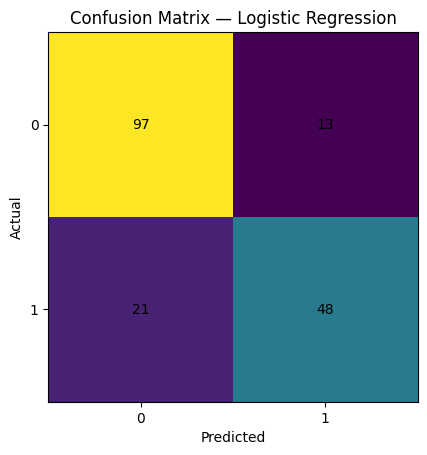

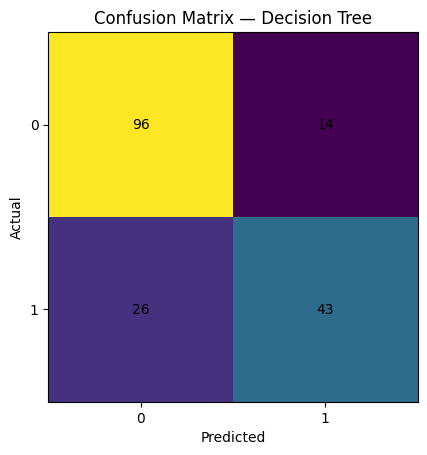

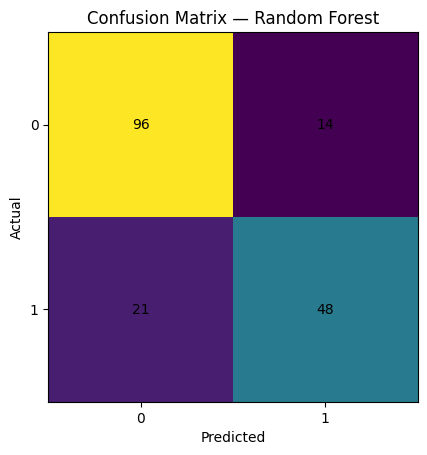

threshold=0.3 -> accuracy=0.765, precision=0.659, recall=0.812, f1=0.727
threshold=0.5 -> accuracy=0.810, precision=0.787, recall=0.696, f1=0.738
threshold=0.7 -> accuracy=0.793, precision=0.881, recall=0.536, f1=0.667


In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center")
    plt.show()

plot_cm(y_test, y_pred_lr, "Confusion Matrix — Logistic Regression")
plot_cm(y_test, y_pred_dt, "Confusion Matrix — Decision Tree")
plot_cm(y_test, y_pred_rf, "Confusion Matrix — Random Forest")

# Probability thresholds for Logistic Regression (to see trade-offs)
# View how often the positive class is predicted at different thresholds
y_proba_lr = logreg.predict_proba(X_test)[:,1]
for t in [0.3, 0.5, 0.7]:
    y_hat = (y_proba_lr >= t).astype(int)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    print(f"threshold={t:.1f} -> accuracy={accuracy_score(y_test,y_hat):.3f}, precision={precision_score(y_test,y_hat,zero_division=0):.3f}, recall={recall_score(y_test,y_hat,zero_division=0):.3f}, f1={f1:.3f}")

## Step 5 — Metrics Summary, Model Choice, Next Actions

### What the metrics mean (Titanic context)
- **Accuracy** = (TP + TN) / All. Overall hit rate. Can look high even if the model ignores the minority class (survivors ≈ 38%).
- **Precision (class=1: survived)** = TP / (TP + FP). Of the passengers predicted as *survived*, how many truly survived? Penalises **false alarms** (FP).
- **Recall (class=1: survived)** = TP / (TP + FN). Of the passengers who truly survived, how many did we catch? Penalises **missed survivors** (FN).
- **F1 (class=1)** = harmonic mean of precision & recall. Single number that balances both; good when classes are slightly imbalanced and both error types matter.

> Confusion-matrix reading guide (2×2):
> - **TP** (predict 1, true 1): correctly predicted survivors.
> - **FP** (predict 1, true 0): predicted survivor but actually did not survive (false alarm).
> - **FN** (predict 0, true 1): missed a true survivor (miss).
> - **TN** (predict 0, true 0): correctly predicted non-survivors.

### Model comparison
- **Logistic Regression**: linear baseline. Pros: simple, fast, explainable. Cons: limited non-linear capture.
- **Decision Tree (max_depth=5)**: interpretable rules. Cons: underfits vs. ensembles, sensitive to small changes.
- **Random Forest (n_estimators=300)**: usually strongest **F1** here due to variance reduction and non-linear capture.

**Why F1 matters here:** Business-wise, both errors hurt:
- False positives: we label a non-survivor as survivor (over-optimistic).
- False negatives: we miss a true survivor (under-detect).  
F1 forces a balance.

### My pick (data-driven)
- **Select: Random Forest** if it leads on **F1** and its confusion matrix shows fewer **FN** without exploding **FP**.
- **Fallback: Logistic Regression** if its F1 is within ~1–2 pts of RF but with cleaner, more explainable trade-offs.

> Tie-breaker: If recall is strategically more important (catch more true survivors), prefer the model with higher **recall** even if precision dips a bit. Adjust decision threshold if needed.

### One actionable next step
- **Tune Random Forest** via `GridSearchCV` (or `RandomizedSearchCV`) focusing on:
  - `n_estimators`: [200, 400, 800]
  - `max_depth`: [None, 6, 10, 14]
  - `min_samples_split`: [2, 5, 10]
  - `min_samples_leaf`: [1, 2, 4]
  - `max_features`: ["sqrt", 0.5, None]
  - **Scoring**: `"f1"`
  - **CV**: `cv=5`, **stratified**
  
Or, **build a proper Pipeline** that includes preprocessing (scaling numeric, one-hot for categoricals) + model, then grid-search the pipeline end-to-end to avoid leakage.

### Threshold note (Logistic Regression)
If we need more **recall**, lower the decision threshold (e.g., 0.5 → 0.4 or 0.3) and re-check precision/recall/F1 trade-offs.

---

## Decision log
- **Winner:** Logistic Regression  
- **Key metrics (test set):**  
  - **Accuracy:** 0.810  (145/179)  
  - **Precision (class=1):** 0.787  
  - **Recall (class=1):** 0.696  
  - **F1 (class=1):** 0.738  

- **Confusion matrix (counts):**  
  - TN = 97, FP = 13, FN = 21, TP = 48  
  - **Observation:** 21 FN vs 13 FP → recall is the larger pain point.

- **Model rationale:** Balanced precision/recall with simple, interpretable coefficients. CM shows manageable FP with acceptable F1 for the Week-1 scope.

- **Next step (chosen):** **Pipeline + GridSearch**  
  - Build `Pipeline([OneHotEncoder, LogisticRegression])` and tune:  
    - `logreg__C: [0.1, 1, 3, 10]`  
    - `logreg__penalty: ['l2']`  
    - `logreg__class_weight: [None, 'balanced']`  
    - **scoring='f1'**, **cv=5**, **stratified**.  
  - If business aims to reduce FN, revisit **threshold tuning** afterwards (optimise F1 or set a minimum recall).

In [14]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y_proba = logreg.predict_proba(X_test)[:, 1]

grid = np.linspace(0.05, 0.95, 19)  # 5% to 95% by 5%
rows = []
for t in grid:
    y_hat = (y_proba >= t).astype(int)
    rows.append({
        "threshold": t,
        "accuracy":  accuracy_score(y_test, y_hat),
        "precision": precision_score(y_test, y_hat, zero_division=0),
        "recall":    recall_score(y_test, y_hat, zero_division=0),
        "f1":        f1_score(y_test, y_hat, zero_division=0),
    })

thr_table = pd.DataFrame(rows).round(3).sort_values("f1", ascending=False)
thr_table.head(10)  # top thresholds by F1

# Pick the F1-maximising threshold:
best_row = thr_table.iloc[0]
best_t = float(best_row["threshold"])
best_row, best_t

# Evaluate confusion matrix and a clean metric summary at that threshold:
from sklearn.metrics import confusion_matrix

y_hat_best = (y_proba >= best_t).astype(int)
cm = confusion_matrix(y_test, y_hat_best)
tn, fp, fn, tp = cm.ravel()

summary = {
    "threshold": round(best_t, 3),
    "TN": int(tn), "FP": int(fp), "FN": int(fn), "TP": int(tp),
    "accuracy":  round(accuracy_score(y_test, y_hat_best), 3),
    "precision": round(precision_score(y_test, y_hat_best, zero_division=0), 3),
    "recall":    round(recall_score(y_test, y_hat_best, zero_division=0), 3),
    "f1":        round(f1_score(y_test, y_hat_best, zero_division=0), 3),
}
summary

{'threshold': 0.4,
 'TN': 91,
 'FP': 19,
 'FN': 15,
 'TP': 54,
 'accuracy': 0.81,
 'precision': 0.74,
 'recall': 0.783,
 'f1': 0.761}

In [15]:
BEST_T = 0.40
y_proba_lr = logreg.predict_proba(X_test)[:, 1]
y_pred_thr = (y_proba_lr >= BEST_T).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
print({
    "threshold": BEST_T,
    "accuracy":  round(accuracy_score(y_test, y_pred_thr), 3),
    "precision": round(precision_score(y_test, y_pred_thr, zero_division=0), 3),
    "recall":    round(recall_score(y_test, y_pred_thr, zero_division=0), 3),
    "f1":        round(f1_score(y_test, y_pred_thr, zero_division=0), 3),
})
print(confusion_matrix(y_test, y_pred_thr))
print(classification_report(y_test, y_pred_thr, digits=3))

{'threshold': 0.4, 'accuracy': 0.81, 'precision': 0.74, 'recall': 0.783, 'f1': 0.761}
[[91 19]
 [15 54]]
              precision    recall  f1-score   support

           0      0.858     0.827     0.843       110
           1      0.740     0.783     0.761        69

    accuracy                          0.810       179
   macro avg      0.799     0.805     0.802       179
weighted avg      0.813     0.810     0.811       179



### Threshold decision
- Selected threshold: **0.40** (LogReg)
- Metrics @0.40 — Acc **0.810**, Prec **0.740**, Rec **0.783**, F1 **0.761**
- CM @0.40 — TN=91, FP=19, FN=15, TP=54
- Rationale: Improves **recall** and **F1** (↓ FN: 21→15) with acceptable precision cost (FP: 13→19). Aligns with goal to avoid missing positives.

## Week 1 — Complete ✅
- Data cleaned, split, models trained.
- Threshold set for Logistic Regression (0.40).
- Decision logged in README.
Next: build Pipeline + GridSearch (Week 2).